# Computation of covariance matrices for the Hubbard chain:
### 1 Setting up the Hamiltonian
### 2 The Mott phase computations
### 3 The superfluid phase computations

# Exact diagonalization routines

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.linalg import expm
import time 


### The Hubbard model will be such that odd sites are down, and even sites are up

In [2]:
L_actual = 5
L = 2*L_actual

In [3]:
from local_matrix_class import *
X = X_class(L)
Y = Y_class(L)
Z = Z_class(L)
S_plus = S_plus_class(L)
S_minus = S_minus_class(L)

In [4]:
tick = time.clock()

Id = np.eye( 2**L )
H_hopping = 0*Id #Trivial initialization of the right size matrix
H_interaction = 0*Id

for x in range(1,L-1):
    H_hopping = H_hopping + S_plus.at(x).dot(Z.at(x+1).dot(S_minus.at(x+2))) + S_minus.at(x).dot(Z.at(x+1).dot(S_plus.at(x+2)))

for x in range(1,L_actual+1):
    H_interaction = H_interaction + (Z.at((2*x))-Id).dot(Z.at((2*x-1))-Id)/4

tock = time.clock()
print ('Time needed to create the Hamiltonian on '+str(L)+' sites is '+str(tock-tick) + ' seconds')

Time needed to create the Hamiltonian on 10 sites is 13.702045 seconds


### Function to ompute covariance matrix

The idea is:
$\Gamma_{x,y} = tr[\hat f_x^\dagger \hat f_y \hat \varrho]  = - tr[\hat S^+_x \ldots Z \ldots Z\hat S^-_y \hat \varrho]$

In [5]:
def compute_cov( rho ):
    Gamma_cov = np.zeros( (L,L), dtype= 'complex' )

    for x in range(1,L+1):
        for y in range(x,L+1):
            obs = S_plus.at(x) 
            for z in range(x,y):
                obs = obs.dot(Z.at(z)) # Note that this range multiplies in Z_x unless x == y so it's -S^+x effectively for x<y
            obs = obs.dot( S_minus.at(y))
            Gamma_cov[ x-1, y-1 ] = np.matrix.trace( obs.dot( rho ))
            Gamma_cov[ y-1, x-1 ] = Gamma_cov[ x-1, y-1 ].conj() 

    return Gamma_cov

# Mott phase computations

### Compute H

In [6]:
beta = 3
U_strength_Mott = 10
tick = time.clock()
rho_beta_Mott = expm( - beta * (H_hopping + U_strength_Mott * H_interaction) )
Z_beta = np.matrix.trace(rho_beta_Mott)
rho_beta_Mott = rho_beta_Mott / Z_beta
tock = time.clock()
print ('Time needed to create the thermal state on '+str(L)+' sites is '+str(tock-tick) + ' seconds')

Time needed to create the thermal state on 10 sites is 6.611677 seconds


### Compute cov

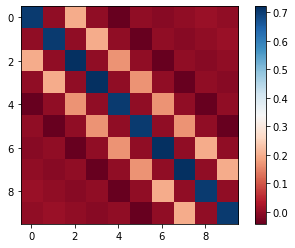

In [7]:
Gamma_cov_Mott = compute_cov(rho_beta_Mott)
plt.figure()
plt.imshow((Gamma_cov_Mott).real, cmap='RdBu')
plt.colorbar()

## Deviation from a Gaussian system in Mott

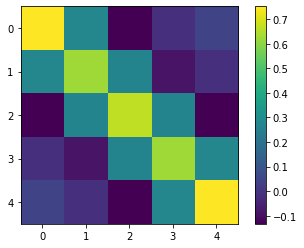

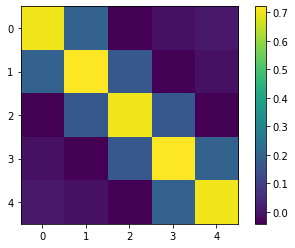

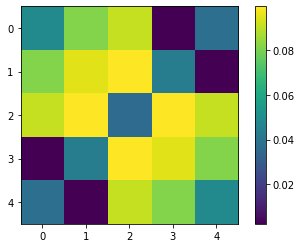

In [8]:
from gaussian_fermions import * #Can be installed with pip install gaussian_fermions

H_nnh = nearest_neighbor_hopping( L_actual )
H_nnh.h = H_nnh.h +.125*U_strength_Mott*np.diag(Gamma_cov_Mott[1::2,1::2].real.diagonal())

cov_Gaussian = H_nnh.cov_thermal(-beta)

np.linalg.norm( cov_Gaussian - Gamma_cov_Mott[::2,::2])

#Gamma_cov = compute_cov( rho_beta )
plt.figure()
plt.imshow(cov_Gaussian)
plt.colorbar()
plt.show()
plt.imshow(Gamma_cov_Mott[::2,::2].real)
plt.colorbar()
plt.show()
plt.imshow(abs(Gamma_cov_Mott[::2,::2]-cov_Gaussian))
plt.colorbar()
plt.show()

In [9]:
Gamma_cov_Mott[1::2,1::2].real.diagonal()

array([0.70347187, 0.7204711 , 0.70345041, 0.7204711 , 0.70347187])

0.0


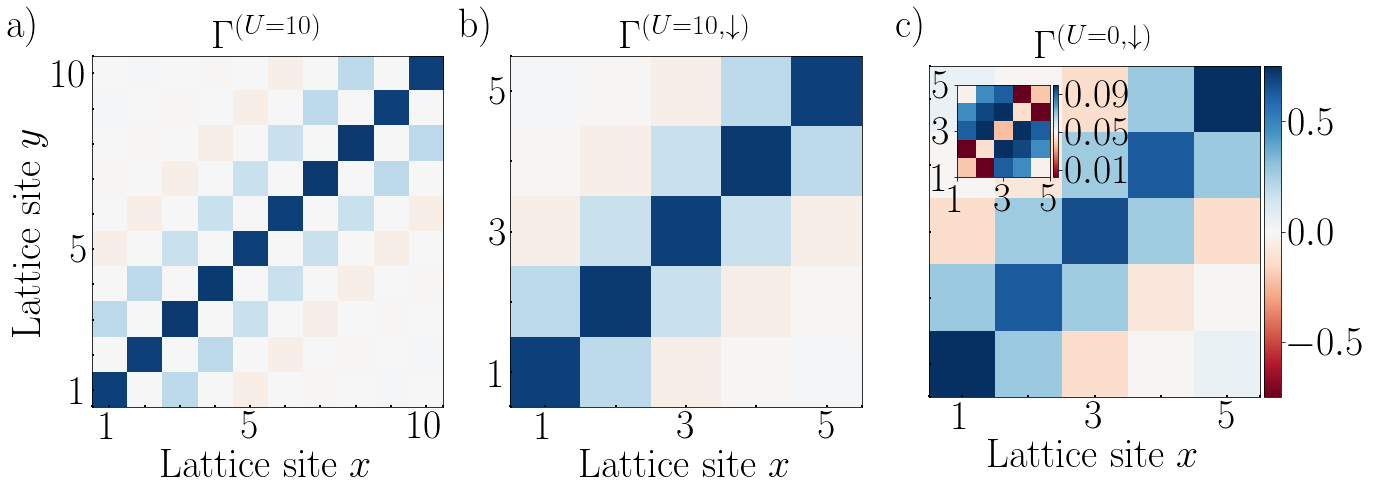

In [10]:
LL = L_actual

save_path = 'figs/app_Hubbard_deviation_Gaussian_L_'+str(L_actual)+'_Ustrength_'+str(U_strength_Mott)+'.pdf'

fontsize = 40
plt.rcParams['axes.labelsize'] = fontsize
plt.rcParams['axes.titlesize'] = fontsize
plt.rcParams['font.size'] = fontsize
#set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['legend.labelspacing'] = .3
plt.rcParams['legend.columnspacing']= .3
plt.rcParams['legend.handletextpad']= .1
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
#Main plot
fig = plt.figure( figsize = ( 20,20 ) )

range_plot = max( [np.max(Gamma_cov_Mott.real), np.max(cov_Gaussian), np.max(cov_Gaussian-Gamma_cov_Mott.real[::2,::2])])
title_str = '$\Gamma^{{(U=%d)}}$' % U_strength_Mott
title_str2 = '$\Gamma^{{(U=%d, \downarrow)}}$' % U_strength_Mott

ax1 = plt.subplot(1,3,1)
plt.imshow(Gamma_cov_Mott.real, cmap='RdBu', origin='lower', aspect='equal', interpolation = None,
           extent = [ 0, LL*2, 0,LL*2], vmin=-range_plot, vmax=range_plot)
plt.title( title_str )
plt.xlim((1,LL*2))
plt.ylim((1,LL*2))
plt.xlabel( 'Lattice site $x$' )
plt.ylabel( 'Lattice site $y$' )
#plt.grid()
ticks = np.append(0,np.linspace(0.5,LL*2-.5,LL*2))
ticks = np.append(ticks,LL*2)
tick_labels = ['']*(len(ticks))
tick_labels[1] = 1
tick_labels[int(LL*2/2)] = int(LL*2/2)
tick_labels[-2] = LL*2
plt.xticks(np.array(ticks),tick_labels)
plt.yticks(np.array(ticks),tick_labels)
ax1.tick_params(direction='in', length=2, width=2, colors='k')

ax2 = plt.subplot(1,3,2)
im2 = ax2.imshow(Gamma_cov_Mott[::2,::2].real, cmap='RdBu', origin='lower', aspect='equal', interpolation = None, 
                               extent = [ 0, LL, 0,LL], vmin=-range_plot, vmax=range_plot)
print(np.linalg.norm(Gamma_cov_Mott.imag))
plt.title( title_str2)
plt.xlim((1,LL))
plt.ylim((1,LL))
plt.xlabel( 'Lattice site $x$' )
#plt.grid()
ticks = np.append(0,np.linspace(0.5,LL-.5,LL))
ticks = np.append(ticks,LL)
tick_labels = ['']*(len(ticks))
tick_labels[1] = 1
tick_labels[3] = 3
tick_labels[-2] = LL

plt.xticks(np.array(ticks),tick_labels)
plt.yticks(np.array(ticks),tick_labels)
ax2.tick_params(direction='in', length=2, width=2, colors='k')

ax_3 = plt.subplot(1,3,3)
im3 = ax_3.imshow(cov_Gaussian, cmap='RdBu', origin='lower', aspect='equal', interpolation = None, 
                               extent = [ 0, LL, 0, LL], vmin=-range_plot, vmax=range_plot)
plt.title( '$\Gamma^{{(U=0, \downarrow)}}$' )
plt.xlim((1,LL))
plt.ylim((1,LL))
plt.xlabel( 'Lattice site $x$' )
#plt.grid()
ticks = np.append(0,np.linspace(0.5,LL-.5,LL))
ticks = np.append(ticks,LL)
tick_labels = ['']*(len(ticks))
tick_labels[1] = 1
tick_labels[3] = 3
tick_labels[-2] = LL

plt.xticks(np.array(ticks),tick_labels)
plt.yticks(np.array(ticks),[])
ax_3.tick_params(direction='in', length=2, width=2, colors='k')

divider = make_axes_locatable(ax_3)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im3, cax=cax)

plt.tight_layout()

inset_pos_x = 0.686
inset_pos_y = 0.535
inset_height = 0.07
inset_width = 0.07

inset = fig.add_axes( [ inset_pos_x, inset_pos_y, inset_width, inset_height ] )
imINS2 = inset.imshow(abs(Gamma_cov_Mott[::2,::2].real-cov_Gaussian) , extent = [ 1, LL, LL,1], cmap='RdBu', 
                   aspect='equal', origin = "lower", interpolation = None)
plt.xlim((1,LL))
plt.ylim((1,LL))
ticks = [1,3,5]
plt.xticks(np.array(ticks),ticks)
plt.yticks(np.array(ticks),ticks)
divider = make_axes_locatable(inset)
caxinset = divider.append_axes("right", size="5%", pad=0.05)
cbar2 = plt.colorbar(imINS2,cax=caxinset)
cbar2.set_ticks( [ .01,0.05,.09])

label_a_x = -22
label_a_y = 0.15
label_b_x = -12.5
label_b_y = 0.15
label_c_x = -3.3
label_c_y = label_b_y
plt.text( label_a_x,label_a_y, 'a)')
plt.text( label_b_x,label_b_y, 'b)')
plt.text( label_c_x,label_c_y, 'c)')


plt.savefig( save_path, format='pdf')
plt.show()


In [11]:
Gamma_cov_Mott[0,0]

(0.7034718676007103-0j)

# Superfluid


### Compute H

In [12]:
beta = 3
U_strength_SF = 1
tick = time.clock()
rho_beta_SF = expm( - beta * (H_hopping + U_strength_SF * H_interaction) )
Z_beta = np.matrix.trace(rho_beta_SF)
rho_beta_SF = rho_beta_SF / Z_beta
tock = time.clock()
print ('Time needed to create the Hamiltonian on '+str(L)+' sites is '+str(tock-tick) + ' seconds')

Time needed to create the Hamiltonian on 10 sites is 4.582971999999998 seconds


### Compute cov


In [13]:
Gamma_cov_SF = compute_cov(rho_beta_SF)


### Show cov

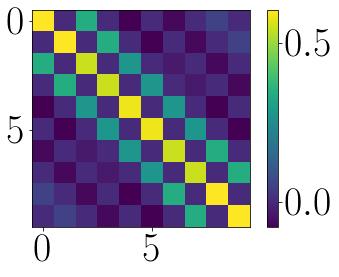

In [14]:
plt.figure()
plt.imshow((Gamma_cov_SF).real)
plt.colorbar()

### Deviation from a Gaussian system

In [15]:
from gaussian_fermions import * #Can be installed with pip install gaussian_fermions

H_nnh = nearest_neighbor_hopping( L_actual )
H_nnh.h = H_nnh.h + 0.125* Gamma_cov_SF[0,0].real*U_strength_SF*np.eye(L_actual)

cov_Gaussian = H_nnh.cov_thermal(-beta)


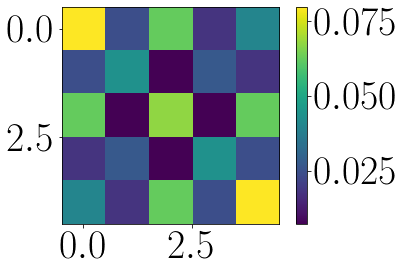

In [16]:

np.linalg.norm( cov_Gaussian - Gamma_cov_SF[::2,::2])

#Gamma_cov = compute_cov( rho_beta )
plt.figure()
plt.imshow(abs(Gamma_cov_SF[::2,::2]-cov_Gaussian))
plt.colorbar()

0.0


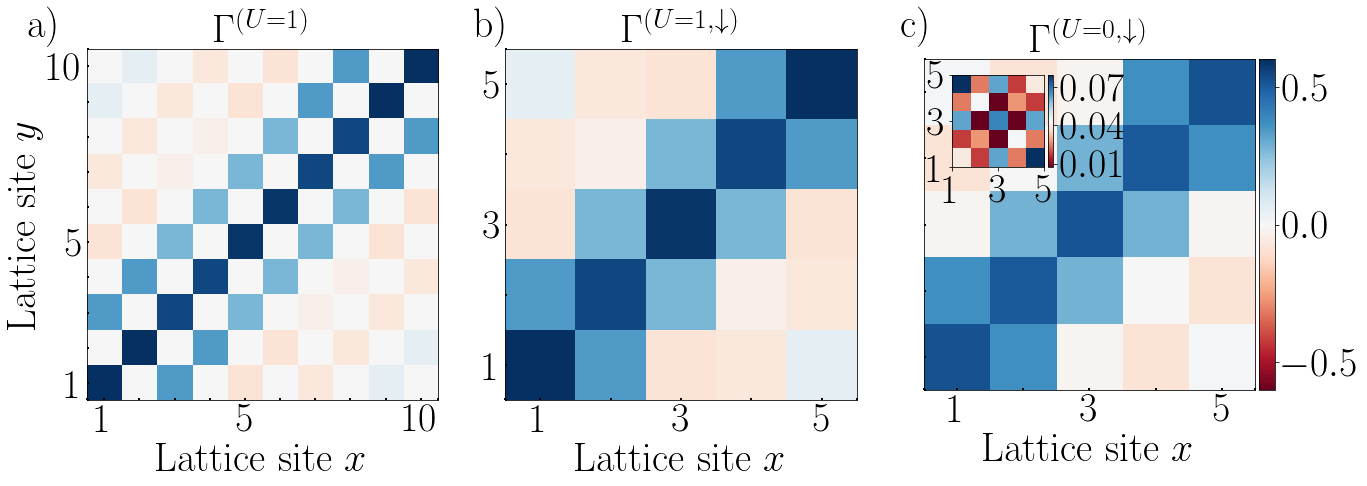

In [17]:
LL = L_actual

save_path = 'figs/app_Hubbard_deviation_Gaussian_SF_L_'+str(L_actual)+'_Ustrength_'+str(U_strength_SF)+'.pdf'

fontsize = 40
plt.rcParams['axes.labelsize'] = fontsize
plt.rcParams['axes.titlesize'] = fontsize
plt.rcParams['font.size'] = fontsize
#set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['legend.labelspacing'] = .3
plt.rcParams['legend.columnspacing']= .3
plt.rcParams['legend.handletextpad']= .1
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
#Main plot
fig = plt.figure( figsize = ( 20,20 ) )

range_plot = max( [np.max(Gamma_cov_SF.real), np.max(cov_Gaussian), np.max(cov_Gaussian-Gamma_cov_SF.real[::2,::2])])
title_str = '$\Gamma^{{(U=%d)}}$' % U_strength_SF
title_str2 = '$\Gamma^{{(U=%d, \downarrow)}}$' % U_strength_SF

ax1 = plt.subplot(1,3,1)
plt.imshow(Gamma_cov_SF.real, cmap='RdBu', origin='lower', aspect='equal', interpolation = None,
           extent = [ 0, LL*2, 0,LL*2], vmin=-range_plot, vmax=range_plot)
plt.title( title_str )
plt.xlim((1,LL*2))
plt.ylim((1,LL*2))
plt.xlabel( 'Lattice site $x$' )
plt.ylabel( 'Lattice site $y$' )
#plt.grid()
ticks = np.append(0,np.linspace(0.5,LL*2-.5,LL*2))
ticks = np.append(ticks,LL*2)
tick_labels = ['']*(len(ticks))
tick_labels[1] = 1
tick_labels[int(LL*2/2)] = int(LL*2/2)
tick_labels[-2] = LL*2
plt.xticks(np.array(ticks),tick_labels)
plt.yticks(np.array(ticks),tick_labels)
ax1.tick_params(direction='in', length=2, width=2, colors='k')

ax2 = plt.subplot(1,3,2)
im2 = ax2.imshow(Gamma_cov_SF[::2,::2].real, cmap='RdBu', origin='lower', aspect='equal', interpolation = None, 
                               extent = [ 0, LL, 0,LL], vmin=-range_plot, vmax=range_plot)
print(np.linalg.norm(Gamma_cov_SF.imag))
plt.title( title_str2)
plt.xlim((1,LL))
plt.ylim((1,LL))
plt.xlabel( 'Lattice site $x$' )
#plt.grid()
ticks = np.append(0,np.linspace(0.5,LL-.5,LL))
ticks = np.append(ticks,LL)
tick_labels = ['']*(len(ticks))
tick_labels[1] = 1
tick_labels[3] = 3
tick_labels[-2] = LL

plt.xticks(np.array(ticks),tick_labels)
plt.yticks(np.array(ticks),tick_labels)
ax2.tick_params(direction='in', length=2, width=2, colors='k')

ax_3 = plt.subplot(1,3,3)
im3 = ax_3.imshow(cov_Gaussian, cmap='RdBu', origin='lower', aspect='equal', interpolation = None, 
                               extent = [ 0, LL, 0, LL], vmin=-range_plot, vmax=range_plot)
plt.title( '$\Gamma^{{(U=0, \downarrow)}}$' )
plt.xlim((1,LL))
plt.ylim((1,LL))
plt.xlabel( 'Lattice site $x$' )
#plt.grid()
ticks = np.append(0,np.linspace(0.5,LL-.5,LL))
ticks = np.append(ticks,LL)
tick_labels = ['']*(len(ticks))
tick_labels[1] = 1
tick_labels[3] = 3
tick_labels[-2] = LL

plt.xticks(np.array(ticks),tick_labels)
plt.yticks(np.array(ticks),[])
ax_3.tick_params(direction='in', length=2, width=2, colors='k')

divider = make_axes_locatable(ax_3)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im3, cax=cax)

plt.tight_layout()

inset_pos_x = 0.686
inset_pos_y = 0.537
inset_height = 0.07
inset_width = 0.07


inset = fig.add_axes( [ inset_pos_x, inset_pos_y, inset_width, inset_height ] )
im_inset = inset.imshow(abs(Gamma_cov_SF[::2,::2].real-cov_Gaussian) , extent = [ 1, LL, LL,1], cmap='RdBu', 
                   aspect='equal', origin = "lower", interpolation = None)
plt.xlim((1,LL))
plt.ylim((1,LL))
ticks = [1,3,5]
plt.xticks(np.array(ticks),ticks)
plt.yticks(np.array(ticks),ticks)
divider = make_axes_locatable(inset)
caxinset = divider.append_axes("right", size="5%", pad=0.05)
cbar2 = plt.colorbar(im_inset, cax = caxinset)
cbar2.set_ticks( [ .01,0.04,.07])

label_a_x = -16
label_a_y = 0.11
label_b_x = -9
label_b_y = 0.11
label_c_x = -2.3
label_c_y = label_b_y
plt.text( label_a_x,label_a_y, 'a)')
plt.text( label_b_x,label_b_y, 'b)')
plt.text( label_c_x,label_c_y, 'c)')

plt.savefig( save_path, format='pdf')
plt.show()
#range_plot = np.max( np.abs( inset_cov ) )
#cbar2.set_clim( -range_plot, range_plot )
#cbar2.set_ticks( [ round(range_plot,1)/2,round(range_plot,1)])

# Deviation by ramping interaction down in finite time: Mott

In [18]:
def ramp_down_simple(N_Trotter_Suzuki, T_ramp = 1):
    dt = T_ramp/N_Trotter_Suzuki
    V_hopping_dt = expm(-1j*dt*H_hopping)
    
    V = np.eye(V_hopping_dt.shape[0])
    for i in range(N_Trotter_Suzuki):
        
        V = V.dot(V_hopping_dt)
        alpha = 1 - i/N_Trotter_Suzuki
        V = V.dot( expm( -1j*dt*alpha*U_strength_Mott*H_interaction) )    
    return V

#### 

$H(t) = H_0 + (1-t/T) H_V$

In [19]:
T_ramps = [ 1, 2, 10 ]

In [20]:
tick = time.clock()
Vs = [ ramp_down_simple(5, T_ramp) for T_ramp in T_ramps ]
tock = time.clock()
print ('Time needed to trotterize is '+str(tock-tick) + ' seconds')

Time needed to trotterize is 172.86581699999996 seconds


In [21]:
rho_ramps = [ V.T.conj().dot( rho_beta_Mott.dot(V)) for V in Vs ]

In [22]:
cov_ts = [ compute_cov(rho_ramp) for rho_ramp in rho_ramps ]

0.028741998945753182
0.07445633608422676
0.05990221376450659


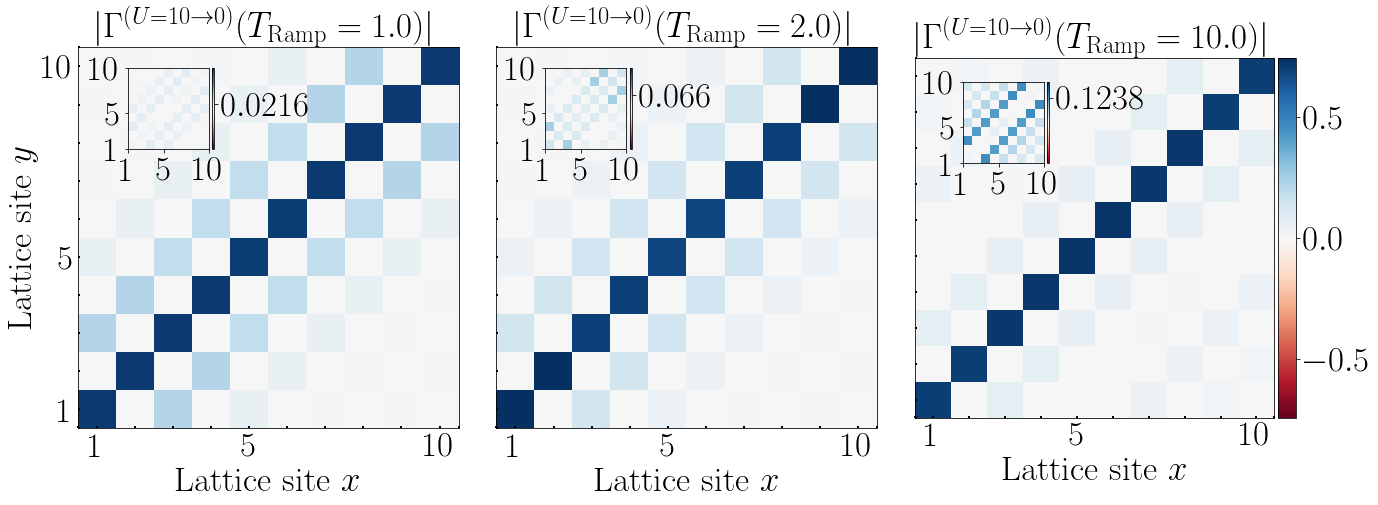

In [35]:
LL = L

save_path = 'figs/app_Hubbard_deviation_Gaussian_Tramp_L_'+str(L_actual)+'_Ustrength_'+str(U_strength_Mott)+'.pdf'

fontsize = 35
plt.rcParams['axes.labelsize'] = fontsize
plt.rcParams['axes.titlesize'] = fontsize
plt.rcParams['font.size'] = fontsize
#set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['legend.labelspacing'] = .3
plt.rcParams['legend.columnspacing']= .3
plt.rcParams['legend.handletextpad']= .1
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
#Main plot
fig = plt.figure( figsize = ( 20,20 ) )

range_plot = max( [np.max(np.abs(cov_ts))])

ax1 = plt.subplot(1,3,1)
plt.imshow(abs(cov_ts[0].real), cmap='RdBu', origin='lower', aspect='equal', interpolation = None,
           extent = [ 0, LL, 0,LL], vmin=-range_plot, vmax=range_plot)
title_str = '$|\Gamma^{{(U=%d \\rightarrow 0)}}(T_{\mathrm{Ramp}} = %.1f )| $' % (U_strength_Mott, T_ramps[0])
plt.title( title_str )
plt.xlim((1,LL))
plt.ylim((1,LL))
plt.xlabel( 'Lattice site $x$' )
plt.ylabel( 'Lattice site $y$' )
#plt.grid()
ticks = np.append(0,np.linspace(0.5,LL-.5,LL))
ticks = np.append(ticks,LL)
tick_labels = ['']*(len(ticks))
tick_labels[1] = 1
tick_labels[5] = 5
tick_labels[-2] = LL

plt.xticks(np.array(ticks),tick_labels)
plt.yticks(np.array(ticks),tick_labels)
ax1.tick_params(direction='in', length=2, width=2, colors='k')

ax2 = plt.subplot(1,3,2)
im2 = ax2.imshow(abs(cov_ts[1]), cmap='RdBu', origin='lower', aspect='equal', interpolation = None, 
                               extent = [ 0, LL, 0,LL], vmin=-range_plot, vmax=range_plot)
print(np.linalg.norm(cov_ts[0].imag))
print(np.linalg.norm(cov_ts[1].imag))
print(np.linalg.norm(cov_ts[2].imag))

title_str = '$|\Gamma^{{(U=%d \\rightarrow 0)}}(T_{\mathrm{Ramp}} = %.1f )|$' % (U_strength_Mott, T_ramps[1])
plt.title( title_str )

plt.xlim((1,LL))
plt.ylim((1,LL))
plt.xlabel( 'Lattice site $x$' )


plt.xticks(np.array(ticks),tick_labels)
plt.yticks(np.array(ticks),[])
ax2.tick_params(direction='in', length=2, width=2, colors='k')

ax_3 = plt.subplot(1,3,3)
im3 = ax_3.imshow(abs(cov_ts[2]), cmap='RdBu', origin='lower', aspect='equal', interpolation = None, 
                               extent = [ 0, LL, 0, LL], vmin=-range_plot, vmax=range_plot)
title_str = '$|\Gamma^{{(U=%d \\rightarrow 0)}}(T_{\mathrm{Ramp}} = %.1f )| $' % ( U_strength_Mott, T_ramps[2])
plt.title( title_str )

plt.xlim((1,LL))
plt.ylim((1,LL))
plt.xlabel( 'Lattice site $x$' )


plt.xticks(np.array(ticks),tick_labels)
plt.yticks(np.array(ticks),[])
ax_3.tick_params(direction='in', length=2, width=2, colors='k')

divider = make_axes_locatable(ax_3)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im3, cax=cax)

plt.tight_layout()

inset_pos_x = 0.11
inset_pos_y = 0.56
inset_height = 0.06
inset_width = 0.06

inset1 = fig.add_axes( [ inset_pos_x, inset_pos_y, inset_width, inset_height ] )
im_inset1 = inset1.imshow(abs(Gamma_cov_Mott-cov_ts[0]) , extent = [ 0, LL, 0,LL], cmap='RdBu', 
                   aspect='equal', origin = "lower", interpolation = None,
                          vmin=-.2, vmax=.2)
plt.xlim((1,LL))
plt.ylim((1,LL))
ticks = [1,5,10]
plt.xticks(np.array(ticks),ticks)
plt.yticks(np.array(ticks),ticks)
divider1 = make_axes_locatable(inset1)
cax_cov_rec1 = divider1.append_axes("right", size="2.5%", pad=0.05)
cbar1 = plt.colorbar(im_inset1, cax = cax_cov_rec1 )
cbar1.set_ticks([np.max(abs(Gamma_cov_Mott-cov_ts[0]))])

inset_pos_x = 0.40
inset_pos_y = 0.56
inset_height = 0.06
inset_width = 0.06

inset2 = fig.add_axes( [ inset_pos_x, inset_pos_y, inset_width, inset_height ] )
im_inset2 = inset2.imshow(abs(Gamma_cov_Mott-cov_ts[1]) , extent = [ 0, LL, 0,LL], cmap='RdBu', 
                   aspect='equal', origin = "lower", interpolation = None,
                          vmin=-.2, vmax=.2)
plt.xlim((1,LL))
plt.ylim((1,LL))
ticks = [1,5,10]
plt.xticks(np.array(ticks),ticks)
plt.yticks(np.array(ticks),ticks)
divider2 = make_axes_locatable(inset2)
cax_cov_rec2 = divider2.append_axes("right", size="2.5%", pad=0.05)
cbar2 = plt.colorbar(im_inset2, cax = cax_cov_rec2 )
cbar2.set_ticks([np.max(abs(Gamma_cov_Mott-cov_ts[1]))])

inset_pos_x = 0.69
inset_pos_y = 0.55
inset_height = 0.06
inset_width = 0.06

inset3 = fig.add_axes( [ inset_pos_x, inset_pos_y, inset_width, inset_height ] )
im_inset3 = inset3.imshow(abs(Gamma_cov_Mott-cov_ts[2]) , extent = [ 0, LL, 0,LL], cmap='RdBu', 
                   aspect='equal', origin = "lower", interpolation = None, 
                          vmin=-.2, vmax=.2)
plt.xlim((1,LL))
plt.ylim((1,LL))
ticks = [1,5,10]
plt.xticks(np.array(ticks),ticks)
plt.yticks(np.array(ticks),ticks)
divider3 = make_axes_locatable(inset3)
cax_cov_rec3 = divider3.append_axes("right", size="2.5%", pad=0.05)
cbar3 = plt.colorbar(im_inset3, cax = cax_cov_rec3 )
cbar3.set_ticks([np.max(abs(Gamma_cov_Mott-cov_ts[2]))])

plt.savefig( save_path, format='pdf')
plt.show()


In [31]:
for i in range(3):
    print(np.max(abs(Gamma_cov_Mott-cov_ts[i])))

0.021595330329548044
0.06591169879625933
0.12381754077187908


In [ ]:
plt.figure()
plt.imshow(abs(cov_ts[0]))
plt.colorbar()
plt.figure()
plt.imshow(abs(cov_ts[1]))
plt.colorbar()
plt.figure()
plt.imshow(abs(cov_ts[2]))
plt.colorbar()
plt.figure()
plt.imshow(abs(cov_ts[0]-cov_ts[2]))
plt.colorbar()
plt.figure()
plt.imshow(abs(cov_ts[1]-cov_ts[2]))
plt.colorbar()
plt.figure()
plt.imshow(abs(Gamma_cov_Mott-cov_ts[2]))
plt.colorbar()

In [ ]:
plt.plot( (Gamma_cov_SF-cov_ts[2]).diagonal().real)